# Analisi del grafico a pettine

## Boring Setup

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Cambiare directory per spostarsi nella cartella principale
import os
while not os.getcwd().endswith('Laboratorio_SiPM'):
    os.chdir('..')

import sys
sys.path.append('Config')
from lablib import *

In [14]:
def crop_df(df: pd.DataFrame, N: int, thr = 0) -> pd.DataFrame:
    """
    Remove groups of consecutive numbers under the threshold from the DataFrame.
    """
    is_zero = df.iloc[:,1] <= thr
    group_id = (is_zero != is_zero.shift()).cumsum()
    removal_mask = pd.Series(False, index=df.index)
    for grp, group_indices in df.groupby(group_id).groups.items():
        if is_zero.loc[group_indices[0]] and len(group_indices) > N:
            removal_mask.loc[group_indices] = True
    return df[~removal_mask].copy()

def cut_df(df: pd.DataFrame, sec: tuple) -> pd.DataFrame:
    """
    Rimuove i dati al di fuori del range definito da sec.
    """
    return df[(df.iloc[:,0] >= sec[0]) & (df.iloc[:,0] <= sec[1])].copy()

def assign_errors(df: pd.DataFrame, lim = 30) -> np.ndarray:
    """
    Assegna un errore a ciascun valore in base al valore stesso.
    L'errore è considerato gaussiano se ci sono abbastanza eventi.
    Se il numero di eventi è minore di lim, va riconsiderato.
    """
    ys = list(df.iloc[:,1])
    tot = np.sum(ys)
    ers = np.zeros(len(df))

    i = 0
    for y in ys:
        if y > lim: # type: ignore
            ers[i] = np.sqrt(y) # type: ignore
        else:
            ers[i] = np.sqrt(lim) # FIXME
            #ers[i] = np.sqrt(y * y/tot * (1 - y/tot))
        i += 1

    return ers

def six_gauss_plus_backgrd(x, mu1, mu2, mu3, mu4, mu5, mu6, 
                           sig1, sig2, sig3, sig4, sig5, sig6,
                           scale1, scale2, scale3, scale4, scale5, scale6, 
                           bkg_mu, bkg_sigma, bkg_scale):
    
    return (scale1*stats.norm.pdf(x, mu1, sig1) +
            scale2*stats.norm.pdf(x, mu2, sig2) +
            scale3*stats.norm.pdf(x, mu3, sig3) +
            scale4*stats.norm.pdf(x, mu4, sig4) +
            scale5*stats.norm.pdf(x, mu5, sig5) +
            scale6*stats.norm.pdf(x, mu6, sig6)) + \
            (bkg_scale * stats.norm.pdf(x, bkg_mu, bkg_sigma))

def eight_gauss_plus_backgrd(x, mu1, mu2, mu3, mu4, mu5, mu6, mu7, mu8,
                            sig1, sig2, sig3, sig4, sig5, sig6, sig7, sig8,
                            scale1, scale2, scale3, scale4, scale5, scale6, scale7, scale8,
                            bkg_mu, bkg_sigma, bkg_scale):
    
    return (scale1*stats.norm.pdf(x, mu1, sig1) +
                scale2*stats.norm.pdf(x, mu2, sig2) +
                scale3*stats.norm.pdf(x, mu3, sig3) +
                scale4*stats.norm.pdf(x, mu4, sig4) +
                scale5*stats.norm.pdf(x, mu5, sig5) +
                scale6*stats.norm.pdf(x, mu6, sig6) +
                scale7*stats.norm.pdf(x, mu7, sig7) +
                scale8*stats.norm.pdf(x, mu8, sig8)) + \
                (bkg_scale * stats.norm.pdf(x, bkg_mu, bkg_sigma))

def calculate_distances(vals: list, ers: list) -> tuple[list, list]:
    distances = []
    errors = []
    for i in range(len(vals)-1):
        distances.append(vals[i+1] - vals[i])

        # per calcolare l'errore della distanza, sommiamo gli errori in quadratura
        # che in questo caso corrisponde alla formula generale di propagazione degli errori
        errors.append(np.sqrt(ers[i]**2 + ers[i+1]**2))

    return distances, errors

In [15]:
root_dir = "Dati/Parte 1/Gain_V//File csv (corretti)/pettine_dark_count_"

pettine53 = pd.read_csv(root_dir+'v53.csv')
pettine53_5 = pd.read_csv(root_dir+'v53_5.csv')
pettine54 = pd.read_csv(root_dir+'v54.csv')
pettine54_5 = pd.read_csv(root_dir+'v54_5.csv')
pettine55_5 = pd.read_csv(root_dir+'v55_5.csv')

thr_noise = 5
thr_sequence = 10
thr_errors = 30

p53 = crop_df(pettine53, thr_sequence, thr_noise) # valore di 5 arbitrario
p53_5 = crop_df(pettine53_5, thr_sequence, thr_noise)
p54 = crop_df(pettine54, thr_sequence, thr_noise)
p54_5 = crop_df(pettine54_5, thr_sequence, thr_noise)
p55_5 = crop_df(pettine55_5, thr_sequence, thr_noise)

p53_err = assign_errors(p53, thr_errors)
p53_5_err = assign_errors(p53_5, thr_errors)
p54_err = assign_errors(p54, thr_errors)
p54_5_err = assign_errors(p54_5, thr_errors)
p55_5_err = assign_errors(p55_5, thr_errors)

## Analisi

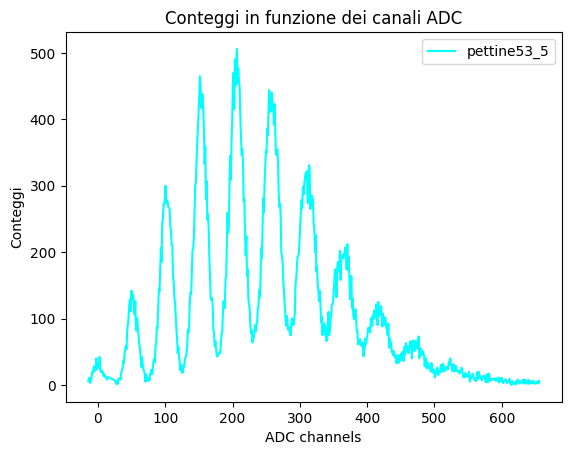

In [16]:
# commentare quelle che non servono

# plt.plot(p53.iloc[:,0], p53.iloc[:,1], label='pettine53', color='blue')
# plt.errorbar(p53.iloc[:,0], p53.iloc[:,1], yerr=p53_err, fmt='o', color='red', markersize=2, label='pettine53 error')

plt.plot(p53_5.iloc[:,0], p53_5.iloc[:,1], label='pettine53_5', color='cyan')
#plt.plot(p54.iloc[:,0], p54.iloc[:,1], label='pettine54', color='red')
#plt.plot(p54_5.iloc[:,0], p54_5.iloc[:,1], label='pettine54_5', color='orange')
#plt.plot(p55_5.iloc[:,0], p55_5.iloc[:,1], label='pettine55_5', color='purple')

plt.xlabel('ADC channels')
plt.ylabel('Conteggi')
plt.title('Conteggi in funzione dei canali ADC')
plt.legend()
plt.show()

### Analisi pettine 53 V

In [17]:
par53, val53, err53, pval53, dof53, qsq53, *other = LS_fit(p53.iloc[:,0], p53.iloc[:,1], p53_err, six_gauss_plus_backgrd, 
                                       mu1=0, mu2=30, mu3=60, mu4=90, mu5=130, mu6=160,
                                       scale1=1e3, scale2=1e4, scale3=1e4, scale4=1e4, scale5=1e4, scale6=5e3,
                                       sig1=10, sig2=10, sig3=10, sig4=10, sig5=10, sig6=10,
                                       bkg_mu=100, bkg_sigma=100, bkg_scale=10000,
                                       disp=0)

if 0: # solo per non farlo uscire sempre
    for i in range(len(par53)):
        print(f"parametro {par53[i]}: {val53[i]:.5g} ± {err53[i]:.5g}")

    print("----------")

    print(f"chi2 ridotto: {qsq53/dof53:.5g}")
    print(f"p-value: {pval53:.5g}")

In [18]:
peaks53 = val53[:6]
sig53 = val53[6:12]

dist53, dist_err53 = calculate_distances(peaks53, err53)

print("Distanze pettine53:")
for i in range(len(dist53)):
    print(f" distanza {i+1}: {dist53[i]:.5g} ± {dist_err53[i]:.5g}")
print("----------")

dist53_mean = np.mean(dist53)
dist53_std = np.sqrt(np.sum([i**2 for i in dist_err53])) / len(dist_err53) # errore medio

print(f"Distanza media pettine 53v: {dist53_mean:.5g} ± {dist53_std:.5g}")

Distanze pettine53:
 distanza 1: 31.396 ± 0.21394
 distanza 2: 31.163 ± 0.15481
 distanza 3: 31.514 ± 0.1573
 distanza 4: 31.779 ± 0.20254
 distanza 5: 32.393 ± 0.33359
----------
Distanza media pettine 53v: 31.649 ± 0.099355


### Analisi Pettine 53.5 V

In [19]:
par53_5, val53_5, err53_5, pval53_5, dof53_5, qsq53_5, *other = LS_fit(p53_5.iloc[:,0], p53_5.iloc[:,1], p53_5_err, eight_gauss_plus_backgrd,
                                                                        mu1=50, mu2=100, mu3=150, mu4=200, 
                                                                        mu5=250, mu6=330, mu7=380, mu8=430,
                                                                        scale1=1e3, scale2=1e4, scale3=1e4, scale4=1e4, 
                                                                        scale5=1e4, scale6=1e4, scale7=1e3, scale8=1e3,
                                                                        sig1=10, sig2=10, sig3=10, sig4=10, 
                                                                        sig5=10, sig6=10, sig7=10, sig8=10,
                                                                        bkg_mu=100, bkg_sigma=100, bkg_scale=10000,
                                                                        disp=1)

if 1:
    for i in range(len(par53_5)):
        print(f"parametro {par53_5[i]}: {val53_5[i]:.5g} ± {err53_5[i]:.5g}")

    print("----------")
    print(f"chi2 ridotto: {qsq53_5/dof53_5:.5g}")
    print(f"p-value: {pval53_5:.5g}")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1267 (χ²/ndof = 2.0)       │             Nfcn = 7040              │
│ EDM = 0.0039 (Goal: 0.0002)      │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu1       │   51.49   │   0.20    │            │            │         │         │       │
│ 1 │ mu2       │  102.12   │   0.12    │            │            │         │         │       │
│ 2 │ mu3       │  153.05   │   0.11    │            │            │         │         │       │
│ 3 │ mu4       │  205.78   │   0.11    │            │            │         │         │       │
│ 4 │ mu5       │  257.76   │   0.13    │            │            │         │         │       │
│ 5 │ mu6       │  310.23   │   0.18    │            │            │         │         │       │
│ 6 │ mu7       │  363.19   │   0.33    │            │            │         │         │       │
│ 7 │ mu8       │    392    │     4     │            │            │         │         │       │
│ 8 │ sig1      │   7.03    │   0.17    │            │            │         │         │       │
│ 9 │ sig2      │   8.51    │   0.10    │            │            │         │         │       │
│ 10│ sig3      │   9.76    │   0.09    │            │            │         │         │       │
│ 11│ sig4      │   10.66   │   0.10    │            │            │         │         │       │
│ 12│ sig5      │   11.37   │   0.14    │            │            │         │         │       │
│ 13│ sig6      │   11.46   │   0.23    │            │            │         │         │       │
│ 14│ sig7      │   10.19   │   0.30    │            │            │         │         │       │
│ 15│ sig8      │   76.2    │    2.9    │            │            │         │         │       │
│ 16│ scale1    │  2.12e3   │  0.06e3   │            │            │         │         │       │
│ 17│ scale2    │  6.08e3   │  0.09e3   │            │            │         │         │       │
│ 18│ scale3    │  10.16e3  │  0.11e3   │            │            │         │         │       │
│ 19│ scale4    │  12.28e3  │  0.13e3   │            │            │         │         │       │
│ 20│ scale5    │  11.74e3  │  0.19e3   │            │            │         │         │       │
│ 21│ scale6    │  7.88e3   │  0.24e3   │            │            │         │         │       │
│ 22│ scale7    │  3.41e3   │  0.15e3   │            │            │         │         │       │
│ 23│ scale8    │  12.7e3   │   0.7e3   │            │            │         │         │       │
│ 24│ bkg_mu    │  -3.31e3  │  0.24e3   │            │            │         │         │       │
│ 25│ bkg_sigma │  1.41e3   │  0.09e3   │            │            │         │         │       │
│ 26│ bkg_scale │  0.83e6   │  0.27e6   │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬───────────────────────────────────────────────────────────────────────────────────────────────────

parametro mu1: 51.487 ± 0.19462
parametro mu2: 102.12 ± 0.12493
parametro mu3: 153.05 ± 0.10829
parametro mu4: 205.78 ± 0.11156
parametro mu5: 257.76 ± 0.13088
parametro mu6: 310.23 ± 0.17834
parametro mu7: 363.19 ± 0.32674
parametro mu8: 391.54 ± 3.9834
parametro sig1: 7.0295 ± 0.17128
parametro sig2: 8.5061 ± 0.10367
parametro sig3: 9.7612 ± 0.09488
parametro sig4: 10.657 ± 0.10303
parametro sig5: 11.369 ± 0.1414
parametro sig6: 11.463 ± 0.23298
parametro sig7: 10.187 ± 0.30107
parametro sig8: 76.216 ± 2.8959
parametro scale1: 2121.7 ± 58.526
parametro scale2: 6079.3 ± 87.747
parametro scale3: 10156 ± 109.2
parametro scale4: 12281 ± 130.55
parametro scale5: 11740 ± 191.37
parametro scale6: 7883 ± 235.76
parametro scale7: 3413.4 ± 146.54
parametro scale8: 12746 ± 662.9
parametro bkg_mu: -3310.2 ± 243.34
parametro bkg_sigma: 1408.1 ± 91.997
parametro bkg_scale: 8.2639e+05 ± 2.7387e+05
----------
chi2 ridotto: 2.0017
p-value: 0


In [20]:
peaks53_5 = val53_5[:8]
sig53_5 = val53_5[8:16]

dist53_5, dist_err53_5 = calculate_distances(peaks53_5, sig53_5)
dist53_5_mean = np.mean(dist53_5)
dist53_5_std = np.sqrt(np.sum([i**2 for i in dist_err53_5])) / len(dist_err53_5)

print(f"Distanza media pettine 53.5v: {dist53_5_mean:.5g} ± {dist53_5_std:.5g}")

Distanza media pettine 53.5v: 48.579 ± 12.079


### Analisi Pettine 53.5V (croppato)

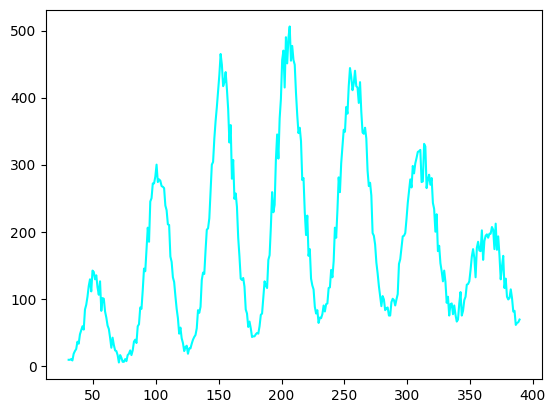

In [ ]:
p53_5_cut = cut_df(p53_5, (30,390))

plt.plot(p53_5_cut.iloc[:,0], p53_5_cut.iloc[:,1], label='pettine53_5', color='cyan')

### Analisi Pettine 54 V

da continuare \
\
non so se continuare ad aumentare il numero di gaussiane o fermarci \
a quante ne abbiamo gia' e prendere solo i picchi piu' alti